In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max.rows',169)
pd.set_option('display.max.columns',169)
pd.set_option('float_format', '{:.2f}'.format)

# Exploracion de la base de datos

In [2]:
df = pd.read_csv('jm_train.csv')
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.47,0.88,-2.05,-1.25,-1.04,-1.93,4
1,-1.03,1.74,-1.66,-1.56,-0.34,-2.47,0
2,-0.56,-0.69,-0.32,-1.85,0.35,-0.91,1
3,-1.27,2.77,1.05,2.83,0.40,0.68,3
4,-1.22,-0.39,-2.90,-0.91,-2.17,-2.37,0


In [3]:
df.shape

(2100, 7)

La base de datos para entrenar cuenta con 2100 filas y 7 columnas

In [4]:
df.info(verbose = True,null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


No se encontraron valores nulos

## Revision estadistica de los datos

In [5]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.00,2100.00,2100.00,2100.00,2100.00,2100.00,2100.00
mean,-0.20,0.20,-0.38,-0.21,-0.19,-0.43,1.98
std,1.54,1.61,1.45,1.44,1.50,1.19,1.41
min,-6.68,-5.38,-6.15,-5.65,-5.91,-4.43,0.00
25%,-1.17,-0.88,-1.37,-1.26,-1.21,-1.13,1.00
50%,-0.44,0.32,-0.44,-0.18,-0.20,-0.41,2.00
75%,0.89,1.32,0.66,0.87,0.85,0.35,3.00
max,4.57,6.70,4.16,4.37,5.07,4.02,4.00


## Variables categoricas y numericas

In [6]:
df.select_dtypes(include = "object").columns

Index([], dtype='object')

In [7]:
df.select_dtypes(include=["int64","float64"]).columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'target'],
      dtype='object')

## Busqueda de valores nulos

In [8]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)

In [9]:
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

In [10]:
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
0,feature1,0,0.00
1,feature2,0,0.00
2,feature3,0,0.00
3,feature4,0,0.00
4,feature5,0,0.00
5,feature6,0,0.00
6,target,0,0.00


## Eliminacion de outliers

In [11]:
from collections import Counter

#drop the label 
outlier_list = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6'] 

def detect_outlier(df,feature):
    
    outlier_indices = []
    
    for f in feature:
        
        #lower quartile
        q1 = np.percentile(df[f],25)
        
        #upper quartile
        q3 = np.percentile(df[f],75)
        
        #interquartile range
        iqr = q3-q1
        
        #with coefficient
        with_coef = 1.5*iqr
        
        #detect outlier(s)
        lower_rule = q1-with_coef
        upper_rule = q3+with_coef
        
        outlier_variable = df[(df[f]<lower_rule) | (df[f]>upper_rule)].index
        outlier_indices.extend(outlier_variable)
    
    #converting to amount
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i,v in outlier_indices.items() if v>2)
    
    return multiple_outliers

 
#drop outliers
df = df.drop(detect_outlier(df,outlier_list),axis=0).reset_index(drop=True)

## Revision del Target

In [12]:
def distributions(df, category_columns):
    plt.figure(figsize = (10,5))
    ax = sns.countplot(x = df[category_columns], data = df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df[category_columns]))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
    plt.show()

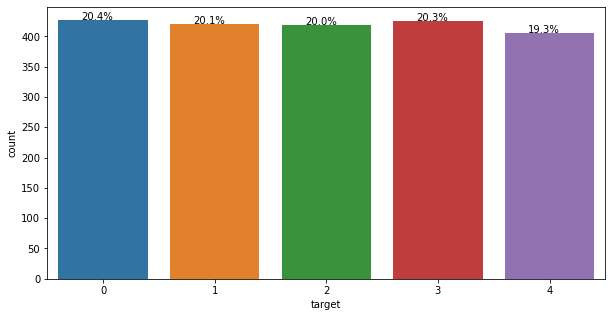

In [13]:
distributions(df,'target')
plt.show()

## Un vistazo a la correlacion de los datos

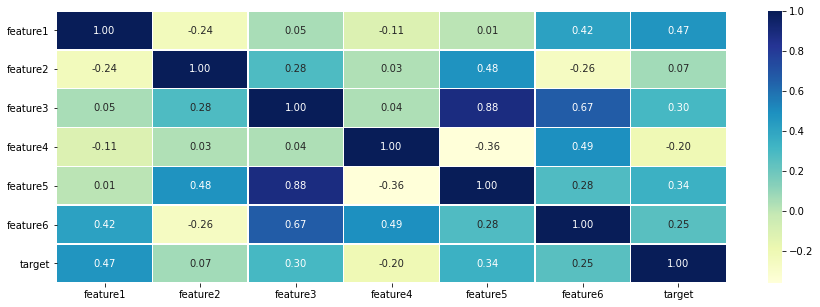

In [14]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu", linewidths=.5,fmt='.2f')
plt.show()

## Distribucion de X y Y

In [15]:
X = df.drop(['target'], axis = 1)
y = df['target']

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier

In [17]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

## Creacion del Pipeline y definicion de hiperparametros

In [18]:
pipelines = {
    'rf': make_pipeline(RandomForestClassifier(random_state=42))
}

In [19]:
for key, value in pipelines.items():
    print(key, type(value))

rf <class 'sklearn.pipeline.Pipeline'>


In [20]:
rf_hyperparameters = {
    'randomforestclassifier__criterion':['entropy','gini'],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_features': ['auto', 0.3, 0.6],
    'randomforestclassifier__min_samples_split':[2,3,10],
    'randomforestclassifier__min_samples_leaf':[1,3,10],
    'randomforestclassifier__bootstrap':[True, False]
}

In [21]:
hyperparameter_grids = {
    'rf': rf_hyperparameters
}

In [22]:
for key in ['rf']:
    if key in hyperparameter_grids:
        if type(hyperparameter_grids[key]) is dict:
            print( key, 'was found, and it is a grid.' )
        else:
            print( key, 'was found, but it is not a grid.' )
    else:
        print( key, 'was not found')

rf was found, and it is a grid.


In [23]:
models = {}

for key in pipelines.keys():
    models[key]= GridSearchCV(pipelines[key], hyperparameter_grids[key], cv=cv, scoring = 'f1_macro',
                             n_jobs= -1,
                             verbose = 1)
    
models.keys()

dict_keys(['rf'])

## Entrenamiento del modelo

In [ ]:
best_estimators = []

for key in models.keys():
    clf = models[key].fit(X,y)
    best_estimators.append(clf.best_estimator_)
    print(key, "is trained and tuned")
    print('Method: {} Best: {}' .format(key,clf.best_estimator_))

Fitting 30 folds for each of 4860 candidates, totalling 145800 fits


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
voting_c = VotingClassifier(estimators=[('rf',best_estimators[0])
                                       ],
                           voting='soft',
                           n_jobs=-1)

In [ ]:
voting_c = voting_c.fit(X,y)

## Resultados

In [ ]:
#Datos con train

print("Score del modelo (accuracy):", round(voting_c.score(X, y), 3))
print("Accuracy score:", round(accuracy_score(voting_c.predict(X), y), 3))
print("Recall score:", recall_score(voting_c.predict(X), y, 
                                           average='micro'))
print("Precision score:", precision_score(voting_c.predict(X), y, average='micro'))
print("F1 score:", f1_score(voting_c.predict(X), y, average='micro'))

In [ ]:
df_test = pd.read_csv("jm_X_test.csv")

In [ ]:
df_test.head()

In [ ]:
df_test['final_status']= voting_c.predict(df_test)

In [ ]:
df_test.head()

In [ ]:
df_test.shape

In [ ]:
#Prediccion = df_test['prediction']

In [ ]:
#Prediccion.to_csv("predictions.csv", header='final_status', index = False)